In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
import matplotlib
import matplotlib.font_manager as fm

import scipy.sparse

import plotly.offline as py
import plotly.express as px

import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf

cf.set_config_file(offline=True, world_readable=False)

try:
    font_location = "HANDotum.ttf"
    font_name = fm.FontProperties(fname = font_location).get_name()
    matplotlib.rc('font', family=font_name)
except:
    print("폰트 임포트 에러")

In [2]:
rv1 = pd.read_csv("../Data/review1_pre.csv", index_col=[0])
rv1 = rv1.drop_duplicates(['Author', 'BookCode'], keep='first')
rv1 = rv1[~pd.isna(rv1["Author"])]

rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
us_list = rv_book_pivot.index
book_list = rv_book_pivot.columns

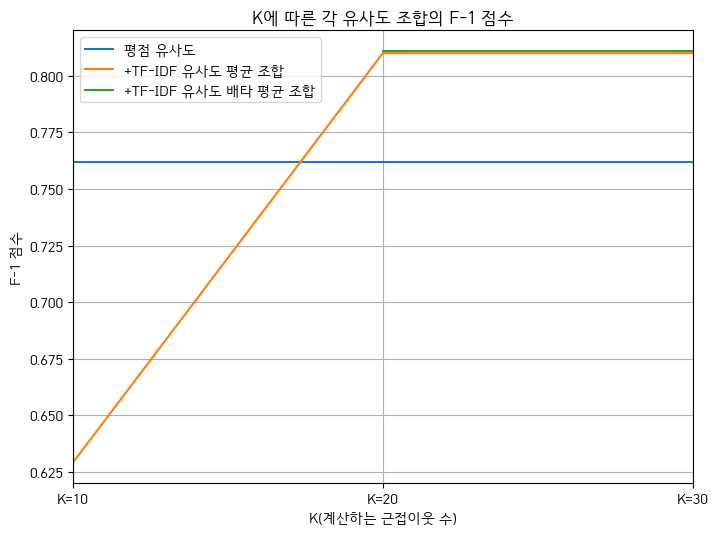

In [5]:
plt.figure(figsize=(8, 6), dpi=100)

plt.subplot(111)

X = np.linspace(0, 2, 3)
f1_norm = [0.762, 0.762, 0.762]
f1_tfidf1 = [0.629, 0.81, 0.81]
f1_tfidf2 = [0.811, 0.811]

plt.plot(X, f1_norm, label="평점 유사도", ls='-')
plt.plot(X, f1_tfidf1, label="+TF-IDF 유사도 평균 조합", ls='-')
plt.plot(X[1:], f1_tfidf2, label="+TF-IDF 유사도 배타 평균 조합", ls='-')

plt.title("K에 따른 각 유사도 조합의 F-1 점수")
plt.legend()
plt.ylabel("F-1 점수")
plt.xlabel("K(계산하는 근접이웃 수)")
plt.xticks([0, 1, 2],
       ['K=10', 'K=20', 'K=30'])
plt.grid(True)
plt.xlim([0, 2])

plt.show()

In [9]:
rv1["SumRate"].iplot(kind="hist", title="리뷰 점수 히스토그램", x)

In [10]:
review_grouped_by_book = rv1.groupby("BookCode")
review_grouped_by_book[["Title"]].count().sort_values("Title", ascending=False).iplot(kind="hist")